# Compares the models from the experiments

In [55]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import pandas as pd

In [56]:
def load_experiments_from_dir(directory):
    experiments = {}
    for file in Path(directory).glob("*.json"):
        with open(file, "r") as f:
            data = json.load(f)
            # Extract model name from filename
            filename = file.stem  # e.g., "piiranha_flair_both_per_experiment"
            model_name = filename.split("_experiment")[0]
            experiments[model_name] = data
    return experiments

In [57]:
def plot_confusion_matrices(experiments):
    num_models = len(experiments)
    cols = 2
    rows = (num_models + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, (model_name, data) in enumerate(experiments.items()):
        cm = np.array(data['confusion_matrix'])
        labels = data['labels']
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels,
                    cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Confusion Matrix: {model_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [58]:
def plot_entity_f2_scores(experiments):
    entity_scores = []
    beta = 2  # for F2 score
    for model, data in experiments.items():
        metrics = data["metrics"]
        for entity in ["LOCATION", "AUT_LICENSE_PLATE", "PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS"]:
            precision = metrics.get(f"{entity}_precision")
            recall = metrics.get(f"{entity}_recall")
            if precision is not None and recall is not None and (precision + recall) > 0:
                f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
                entity_scores.append({
                    "Model": model,
                    "Entity": entity,
                    "F2 Score": f2
                })

    df = pd.DataFrame(entity_scores)
    df = df.sort_values(by="F2 Score", ascending=False)

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df, x="Entity", y="F2 Score", hue="Model", dodge=True, order=df["Entity"])
    plt.title("Entity-Level F2 Scores (Recall-Focused)")
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [59]:
def plot_pii_f_scores(experiments):
    # Extract and sort models by pii_f score
    sorted_models = sorted(experiments.items(), key=lambda x: x[1]['metrics']['pii_f'], reverse=True)
    model_names = [model for model, _ in sorted_models]
    pii_f_scores = [data['metrics']['pii_f'] for _, data in sorted_models]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=pii_f_scores, palette="viridis")
    plt.ylabel("PII F1 Score")
    plt.xlabel("Model Name")
    plt.title("PII F1 Score per Model (Descending)")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


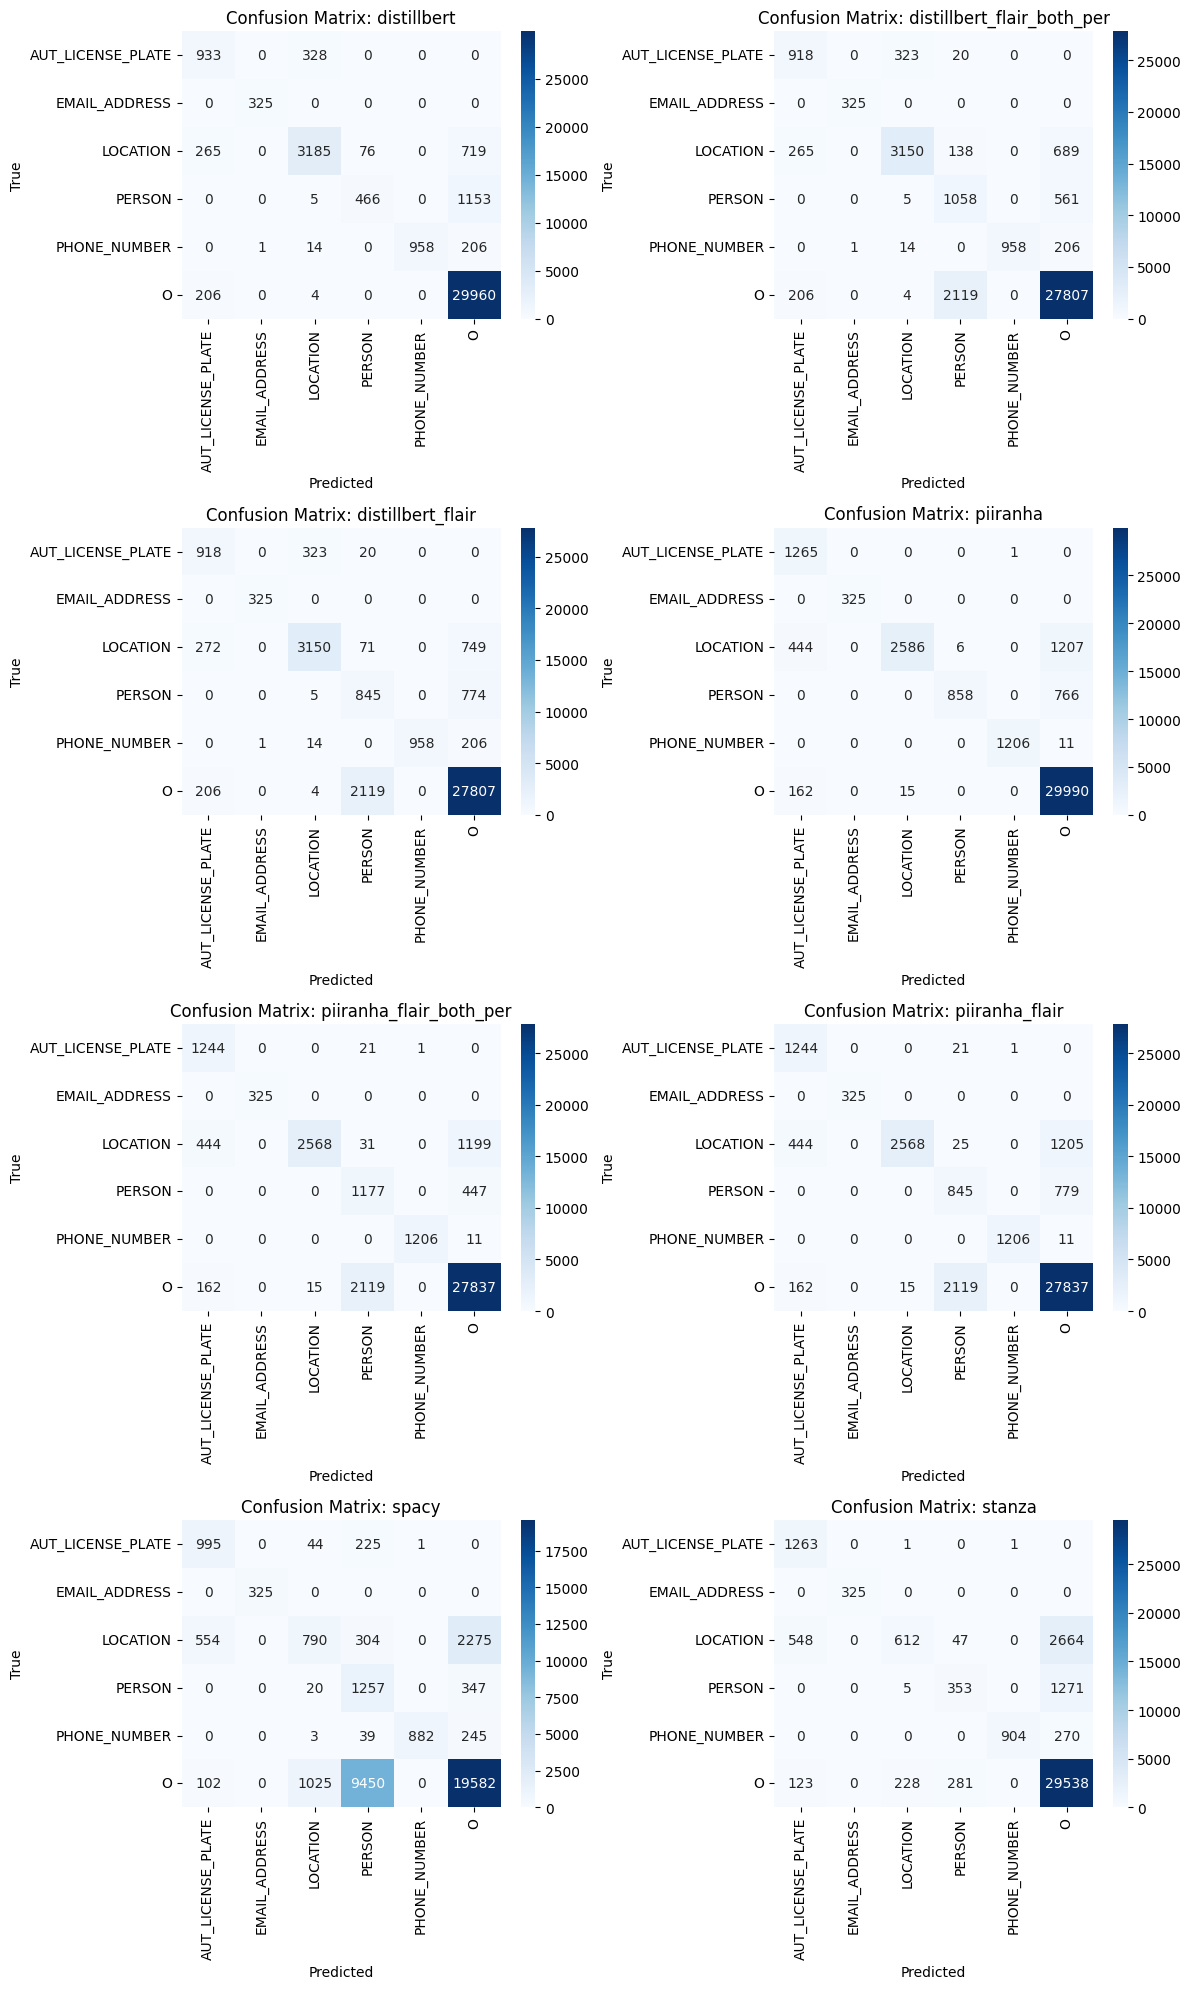

C:\Users\Alan\AppData\Local\Temp\ipykernel_2744\320393133.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=pii_f_scores, palette="viridis")


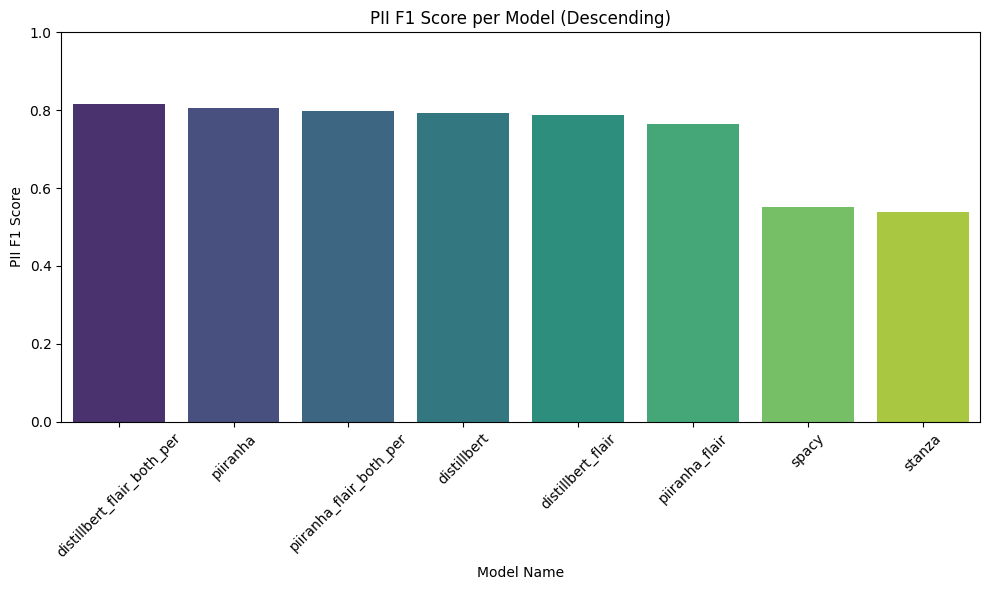

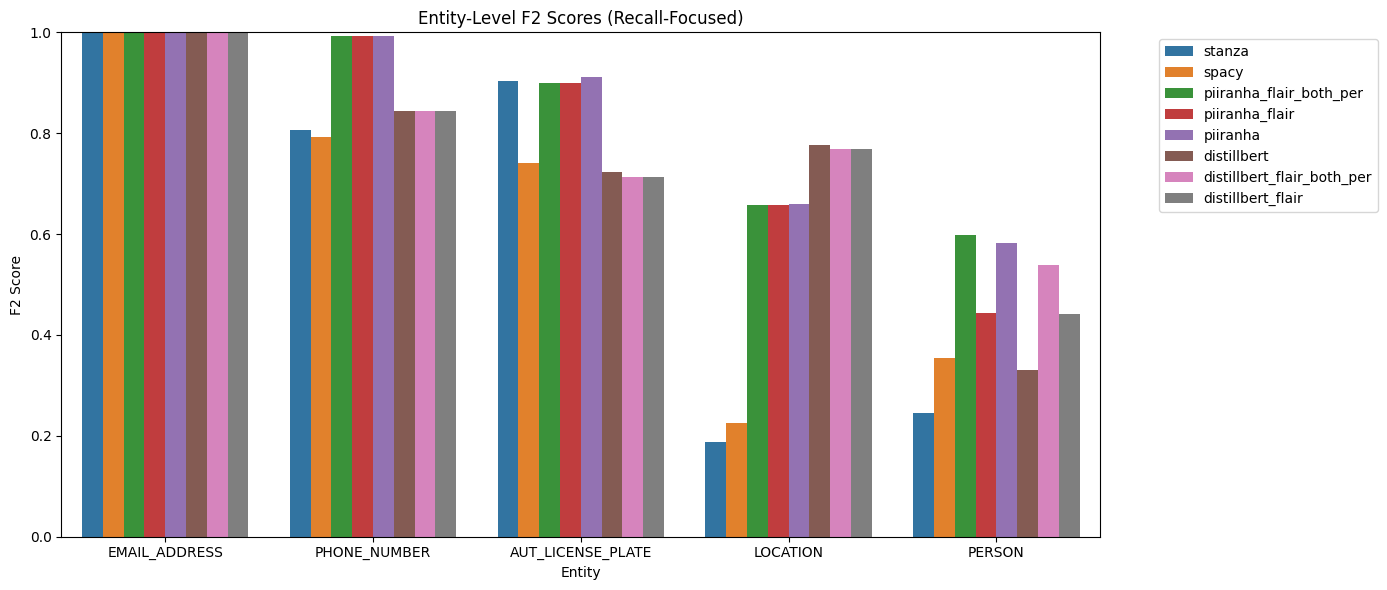

In [60]:
experiments = load_experiments_from_dir("results/dataset_april_11")
plot_confusion_matrices(experiments)
plot_pii_f_scores(experiments)
plot_entity_f2_scores(experiments)